In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

2025-09-23 22:55:49.229500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758668149.563172      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758668149.655999      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Proje boyunca kullanacağımız gerekli kütüphaneleri içeri aktarıyoruz.
Son kısımdaki warnings filtresi python'un kodun çalışmasına engel olmayan, ama dikkat etmeni isteyen bazı mesajları görmezden gelebilmeyi sağlamak için vardır.

In [2]:
data_dir = '/kaggle/input/corn-or-maize-leaf-disease-dataset/data'
ds_name = 'Leaf_Disease'

Veri klasörünü içeri aktarıyoruz ve datasetimizi isimlendiriyoruz.

In [3]:
def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

İçeri aktardığımız veri klasörünü hazır olarak direk kullanamayız. Bu yüzden klasör alt klasörlerine ayrılır, bütün alt klasörlerin dosyaları listelenir ve her bir dosyaya etiketler atanarak ayrıştırılır.

In [4]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

df_sample = df.sample(n=10, random_state=42).reset_index(drop=True)

print(tabulate(df_sample, headers='keys', tablefmt='fancy_grid', showindex=True))

╒════╤═══════════════════════════════════════════════════════════════════════════════════════════════╤════════════════╕
│    │ filepaths                                                                                     │ labels         │
╞════╪═══════════════════════════════════════════════════════════════════════════════════════════════╪════════════════╡
│  0 │ /kaggle/input/corn-or-maize-leaf-disease-dataset/data/Blight/Corn_Blight (742).JPG            │ Blight         │
├────┼───────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┤
│  1 │ /kaggle/input/corn-or-maize-leaf-disease-dataset/data/Gray_Leaf_Spot/Corn_Gray_Spot (368).jpg │ Gray_Leaf_Spot │
├────┼───────────────────────────────────────────────────────────────────────────────────────────────┼────────────────┤
│  2 │ /kaggle/input/corn-or-maize-leaf-disease-dataset/data/Blight/Corn_Blight (792).JPG            │ Blight         │
├────┼──────────────────────────────────

pd.Series() fonksiyonu ile filepath ve label'ları pandas series haline getiriyor bunun yanı sıra pd.concat() ile iki series yan yana birleştiriliyor ve iki sütunlu bir dataframe ortaya çıkıyor. Yukarıdaki çıktı üzerinden de bunu rahatlıkla anlayabiliyoruz.

The Leaf_Disease dataset has 4188 images.

The Leaf_Disease dataset has 4 classes

Class 'Common_Rust' has 1306 images


Class 'Blight' has 1146 images


Class 'Healthy' has 1162 images


Class 'Gray_Leaf_Spot' has 574 images




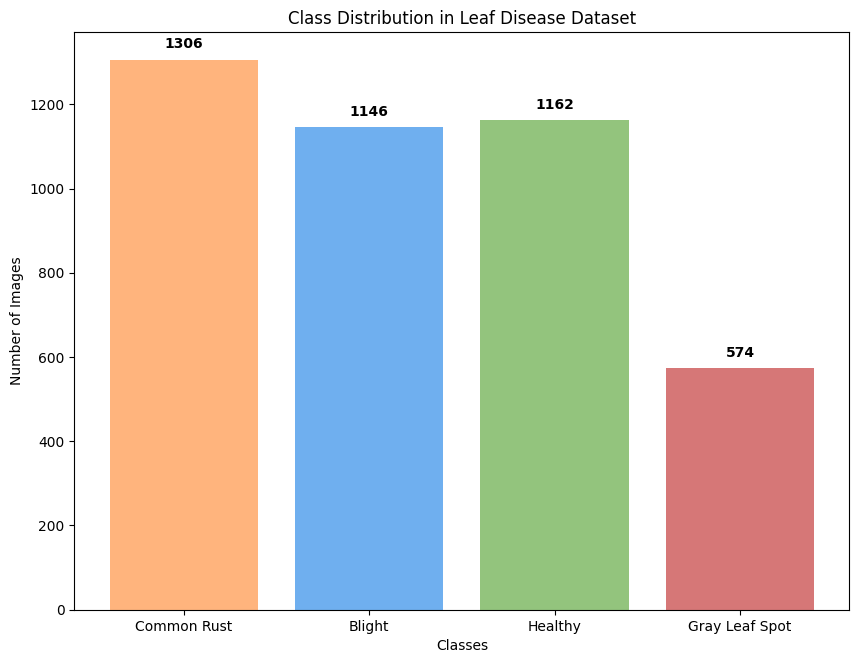

In [5]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")
    
num_of_examples(df, ds_name)
print()

def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

def classes_count(df, name='df'):
    
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('\n')
        
classes_count(df, ds_name)

class_num=len(df['labels'].unique())

# Sınıf isimleri ve örnek sayıları
classes = ['Common Rust', 'Blight', 'Healthy', 'Gray Leaf Spot']
counts = [1306, 1146, 1162, 574]

# Bar chart
plt.figure(figsize=(10,7.5))
bars = plt.bar(classes, counts, color=['#FFB47D','#6FAFEF','#93C47D','#D67777'])

# Barların üzerine sayıları yaz
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, yval, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Class Distribution in Leaf Disease Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

Yukarıda görmüş olduğunuz hem yazılı metinle hem de grafikle beraber kaç sınıfımız olduğunu ve her bir sınıfa ne kadar görsel düştüğünü rahatlıkla gözlemleyebilirsiniz.

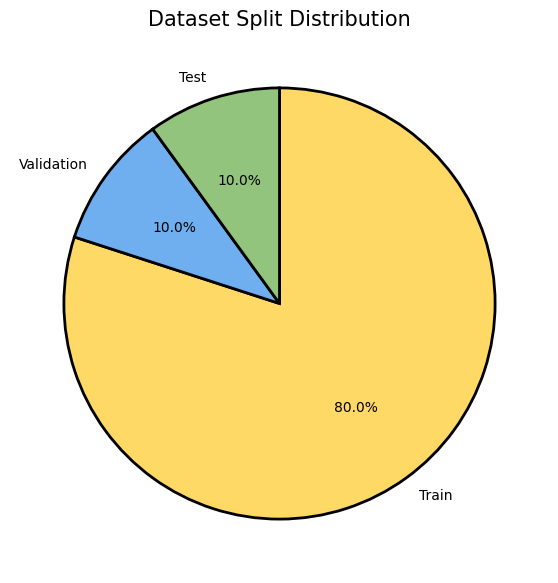

In [6]:
train_df, dummy_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 42)

valid_df, test_df = train_test_split(dummy_df, train_size= 0.5, shuffle= True, random_state= 42)

# Split sonrası veri sayıları
sizes = [len(train_df), len(valid_df), len(test_df)]
labels = ['Train', 'Validation', 'Test']
colors = ['#FFD966', '#6FAFEF', '#93C47D']

# Pasta grafiği
plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor':'black', 'linewidth':2}
)
plt.title("Dataset Split Distribution", fontsize=15)
plt.show()

In [7]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.5, 1.2],
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator(
    rescale=1./255
)

# Train generator flow
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Validation generator flow
valid_gen = val_test_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  
    batch_size=batch_size
)

# Test generator flow
test_gen = val_test_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  
    batch_size=batch_size
)

Found 3350 validated image filenames belonging to 4 classes.
Found 419 validated image filenames belonging to 4 classes.
Found 419 validated image filenames belonging to 4 classes.


Image_Data_Generator fonksiyonuyla beraber görseli çevirme, yakınlaştırma, döndürme gibi yollarla train veri setine augmentation ve preprocessing uygulanır fakat validation ve test veri setine yalnızca preprocessing uygulanır. Aynı zamanda çıktı kısmında sırasıyla train, validation ve test veri setine kaç adet görsel düştüğü gözükmektedir. One-hot encoding de |class_mode='categorical'| bu kısımda keras tarafından otomatik olarak gerçekleşmektedir.

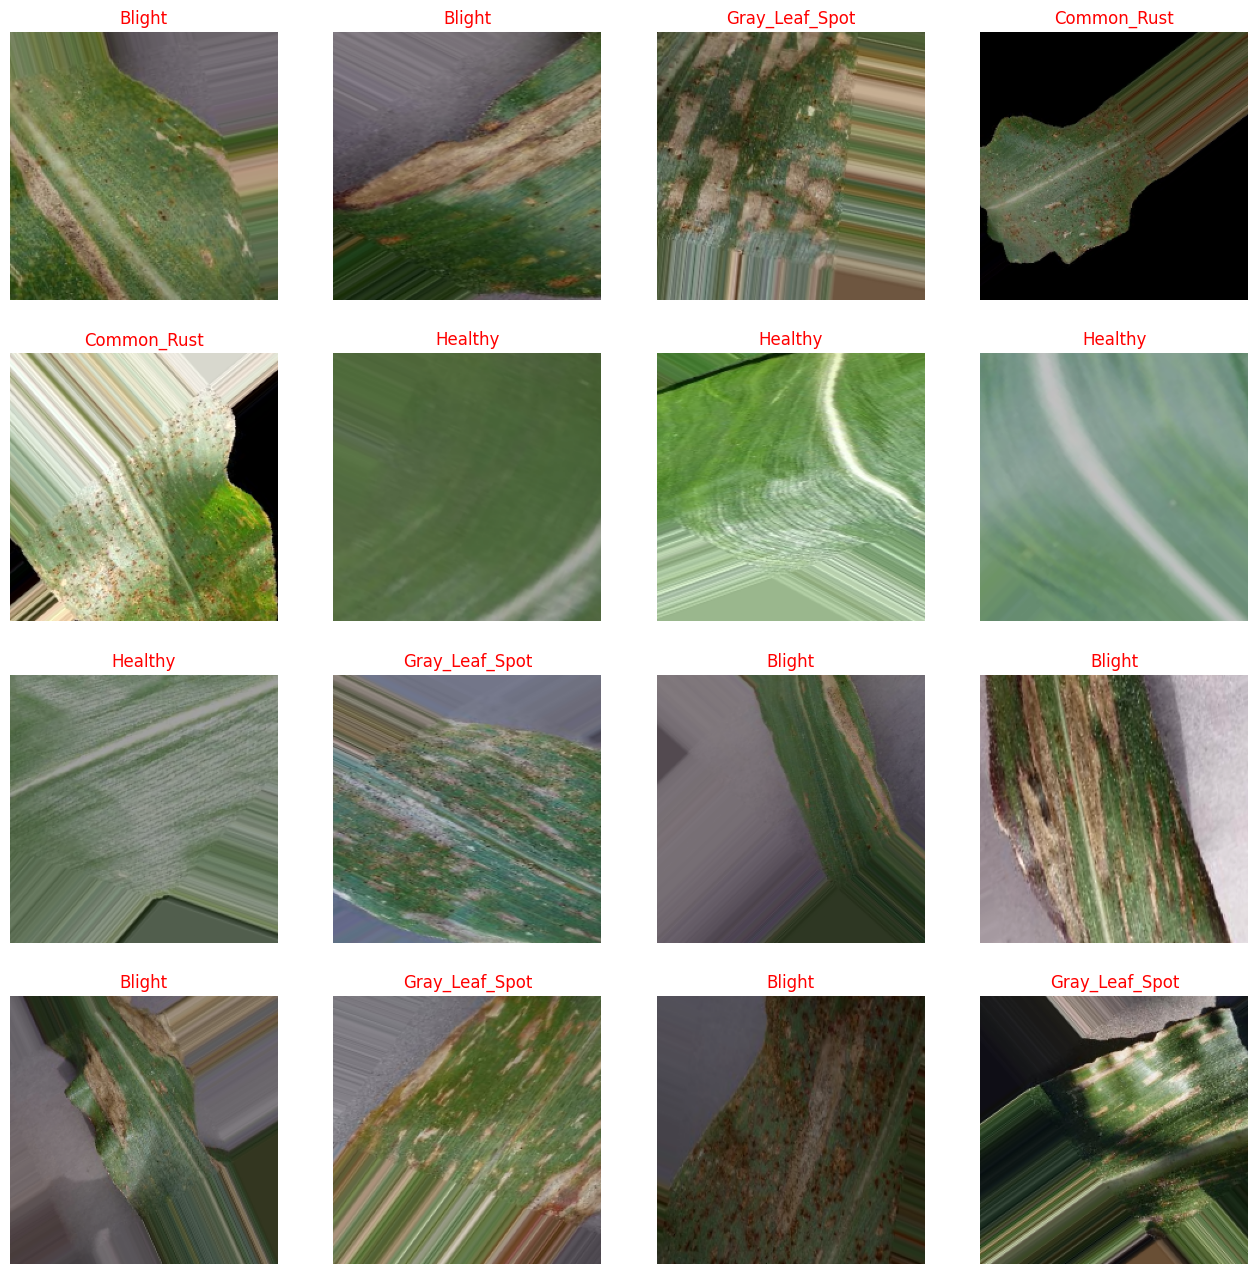

In [8]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (16, 16))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'red', fontsize= 12)
    plt.axis('off')
    
plt.show()

Bu kısımda train data setini görselleştiriyoruz ve augmentation yaptığımız için çevirme, döndürme, yakınlaştırma, karartma gibi değişikliklerin görsellere nasıl yansıdığını net bir şekilde görebiliyoruz.

In [9]:
results = {}

def create_cnn_model(dropout_rate=0.4):
    # CNN Modeli örneği
    model = keras.Sequential([
    # 1. Conv Block
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    # 2. Conv Block
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    # 3. Conv Block
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    # Fully Connected
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_rate),
    
    # Output Layer
    keras.layers.Dense(class_num, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))
    ])

    return model

cnn_modelv1 = create_cnn_model()

cnn_modelv1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), #optimizer ve öğrenme oranı tercihi
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)  #eğitimin belli kıstasları karşılamaması durumunda erkenden süreci durduruyoruz.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)  #val_loss verisine istinaden eğitim esnasında learning rate oranını düşürüyoruz.

# Modeli eğit
history = cnn_modelv1.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=8,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Son epoch validation accuracy'i kaydet
results[f'val_accuracy_dropout(0.4)'] = history.history['val_accuracy'][-1]

# Sonuçları yazdır
for key, value in results.items():
    print(f"Son {key} değeri: {value:.4f}")

I0000 00:00:1758668236.918409      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758668236.919126      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/8


I0000 00:00:1758668241.877283      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6746 - loss: 1.2140 - val_accuracy: 0.2196 - val_loss: 7.3139 - learning_rate: 0.0010
Epoch 2/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7915 - loss: 0.5965 - val_accuracy: 0.2196 - val_loss: 7.6041 - learning_rate: 0.0010
Epoch 3/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8094 - loss: 0.5199 - val_accuracy: 0.2196 - val_loss: 7.0820 - learning_rate: 0.0010
Epoch 4/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8037 - loss: 0.5116 - val_accuracy: 0.2220 - val_loss: 5.8550 - learning_rate: 0.0010
Epoch 5/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8194 - loss: 0.4830 - val_accuracy: 0.2267 - val_loss: 4.5057 - learning_rate: 0.0010
Epoch 6/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8357 - loss: 0.4246 - val_accuracy: 0.2458 - val_loss: 3.8861 - learning_rate: 0.0010
Epoch 7/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8465 - loss: 0.4283 - val_accuracy: 0.2267 - val_loss

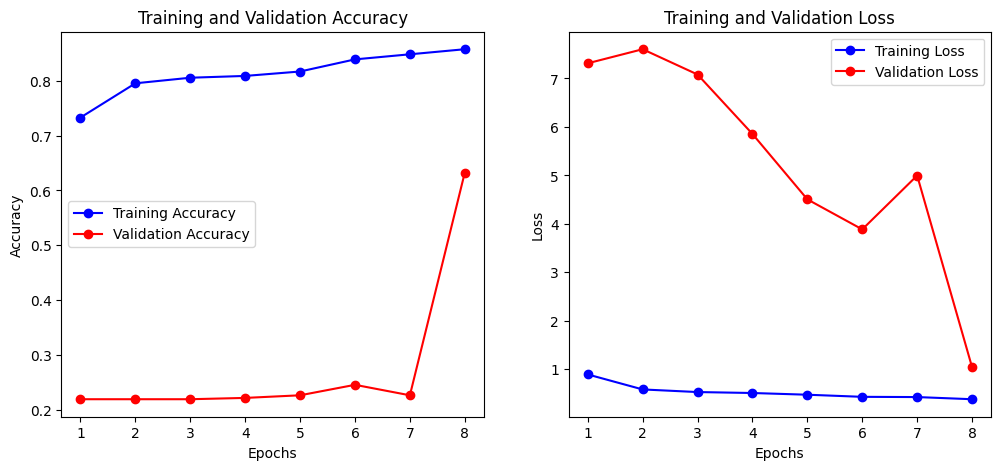

In [10]:
# Eğitim ve validation verilerini history'den al
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# Accuracy grafiği
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.6756 - loss: 0.9635

Test Kaybı: 1.0056
Test Doğruluğu: 0.6683

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step

Sınıflandırma Raporu:
                precision    recall  f1-score   support

   Common_Rust       1.00      0.03      0.05       109
        Blight       0.96      0.90      0.93       142
       Healthy       0.42      0.69      0.52        61
Gray_Leaf_Spot       0.59      1.00      0.74       107

      accuracy                           0.67       419
     macro avg       0.74      0.65      0.56       419
  weighted avg       0.80      0.67      0.59       419



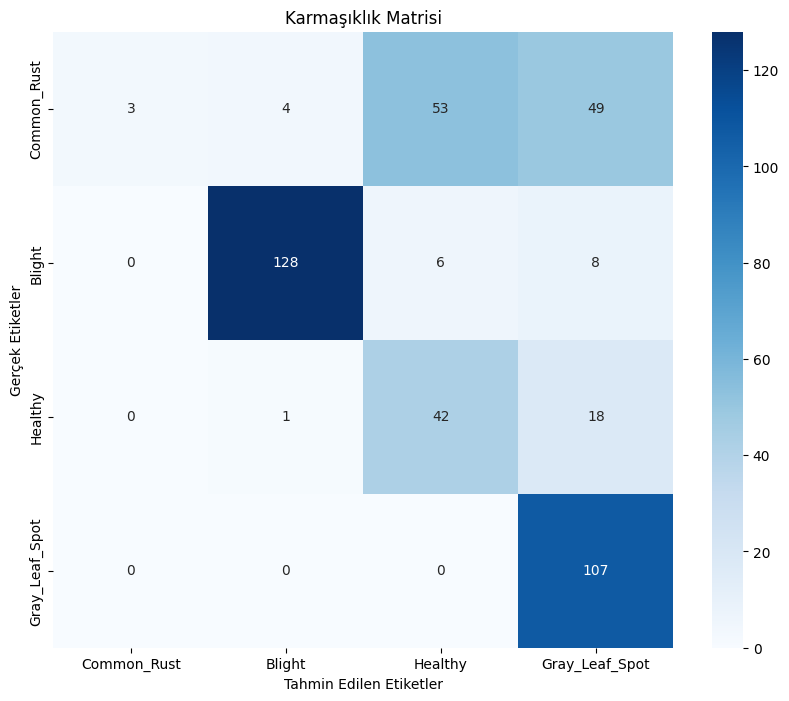

In [11]:
# Class isimlerini df'den alıyoruz
class_names = df['labels'].unique()

# Test seti üzerinde modeli değerlendirelim
test_loss, test_accuracy = cnn_modelv1.evaluate(test_gen, verbose=1)
print(f"\nTest Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}\n")

# Tahminlerde bulunalım
y_pred = cnn_modelv1.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# test_gen'deki gerçek etiketler
y_true = test_gen.classes

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Edilen Etiketler')
plt.show()

In [ ]:
cnn_modelv2 = create_cnn_model(0.6)

cnn_modelv2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), #optimizer ve öğrenme oranı tercihi
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = cnn_modelv2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=2,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Son epoch validation accuracy'i kaydet
results[f'val_accuracy_dropout(0.6)'] = history.history['val_accuracy'][-1]

# Sonuçları yazdır
for key, value in results.items():
    print(f"Son {key} değeri: {value:.4f}")